# Simulation

推定地が実際のデータをうまく再現できるかをチェックする

simulationの対象はmunicipality別の、候補者ごとの得票率

実際のデータではdataの3~6行が候補者別のvote数（clark, dean, edwards, kerryの順番）

データの見せ方は以下の二つ
- 州ごとにmunicipalityを候補者二人の得票率を軸とした六つの散布図にプロットする
- 州ごとにmunicipalityの結果を集計し、時系列データとして候補者ごとの得票率をプロットする

ひとまず実際のデータを上のようにプロットする

In [3]:
using Optim
using StatsFuns
using DataFrames
using Gadfly
using PyPlot

# inverse beta distribution function を行列に対応するように拡張
import StatsFuns.betainvcdf
betainvcdf(alpha::Number, beta::Number, x::Array) = reshape([betainvcdf(alpha, beta, i) for i in reshape(x, 1, size(x, 1)*size(x, 2)) ], size(x, 1), size(x, 2))

# maxをArray{String, 1}に対応するように拡張
# しかしArray型で入っているのでAnyに対応させる
import Base.max
max(number::Real, comparison::Any) = [max(number, parse(Int, i)) for i in comparison] 

# normpdfを配列に拡張
import StatsFuns.normpdf
normpdf(array::Array{Float64, 2}) = reshape([normpdf(i) for i in reshape(array, 1, size(array, 1)*size(array, 2))], size(array, 1), size(array, 2))

# Candを作る
include("bayes.jl");

INFO: Precompiling module PyPlot.


In [15]:
# S は州を表す。35まである。
# Votes_sは州ごとに、内部のmunicipality別の候補者ごとの得票率を格納する。
S = 4
DeltaO  = 0.6891
DeltaMO = 0.5366
DELTA = DeltaO*Open+DeltaMO*MOpen
RTOT = RDemHat.*(1+DELTA)-VOther
RTot_s = RTOT[Cand[S, 14]:Cand[S, 15], :]
RTot_s = max(RTot_s, sum(Votes[Cand[S, 14]:Cand[S, 15], :], 2))
Votes_s = Votes[Cand[S, 14]:Cand[S, 15], :]./(RTot_s*ones(1,4)) #vote share data

41×4 Array{Float64,2}:
 0.0076379   0.00880019  0.0109587  0.0458274
 0.00772797  0.00869397  0.0117852  0.046561 
 0.00862861  0.00893678  0.0110939  0.0463788
 0.0107631   0.00612017  0.0088637  0.0525491
 0.0140545   0.0128833   0.018505   0.0597314
 0.0143618   0.0207733   0.0233379  0.0854014
 0.0275983   0.0270995   0.0137991  0.102579 
 0.034351    0.0445832   0.0281386  0.181256 
 0.043957    0.0460174   0.0418965  0.206392 
 0.0331478   0.0269494   0.0280274  0.135556 
 0.0286574   0.0252859   0.024724   0.120811 
 0.00937208  0.0111495   0.0113111  0.0607569
 0.0178831   0.0163376   0.0112597  0.109727 
 ⋮                                           
 0.0331755   0.0384414   0.0308058  0.147447 
 0.0128891   0.012531    0.0175435  0.07268  
 0.0109502   0.00610683  0.0157935  0.0440113
 0.00873308  0.00764145  0.0165565  0.0491236
 0.0236269   0.0363908   0.0532284  0.187657 
 0.00461682  0.00400125  0.0123115  0.0309327
 0.00989671  0.0127758   0.0199734  0.0680174
 0.00908956

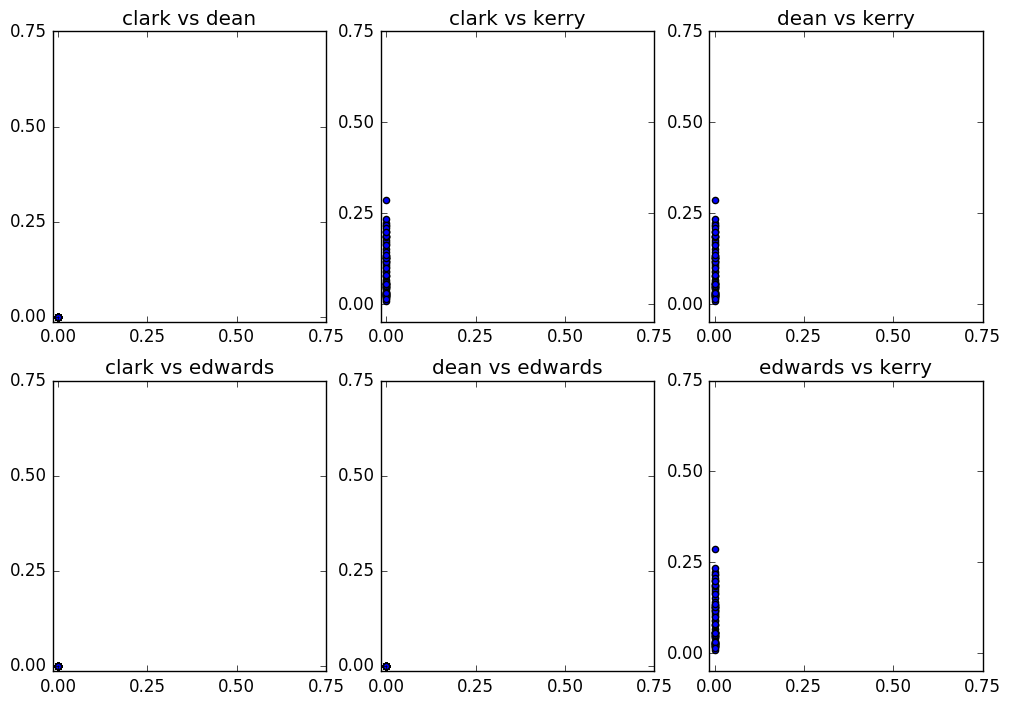

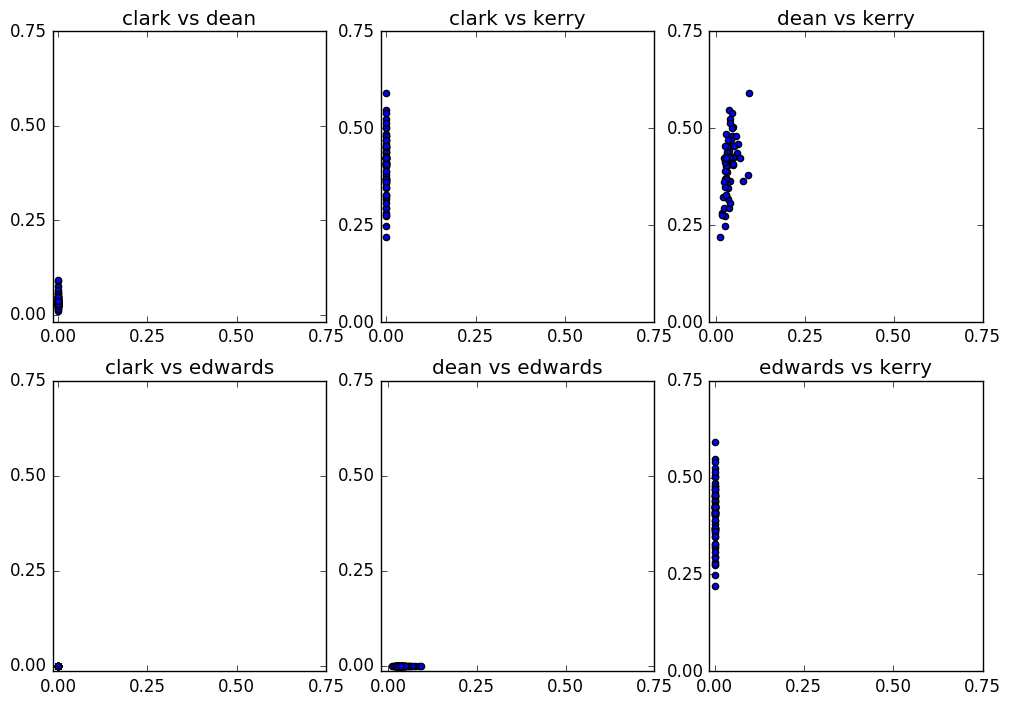

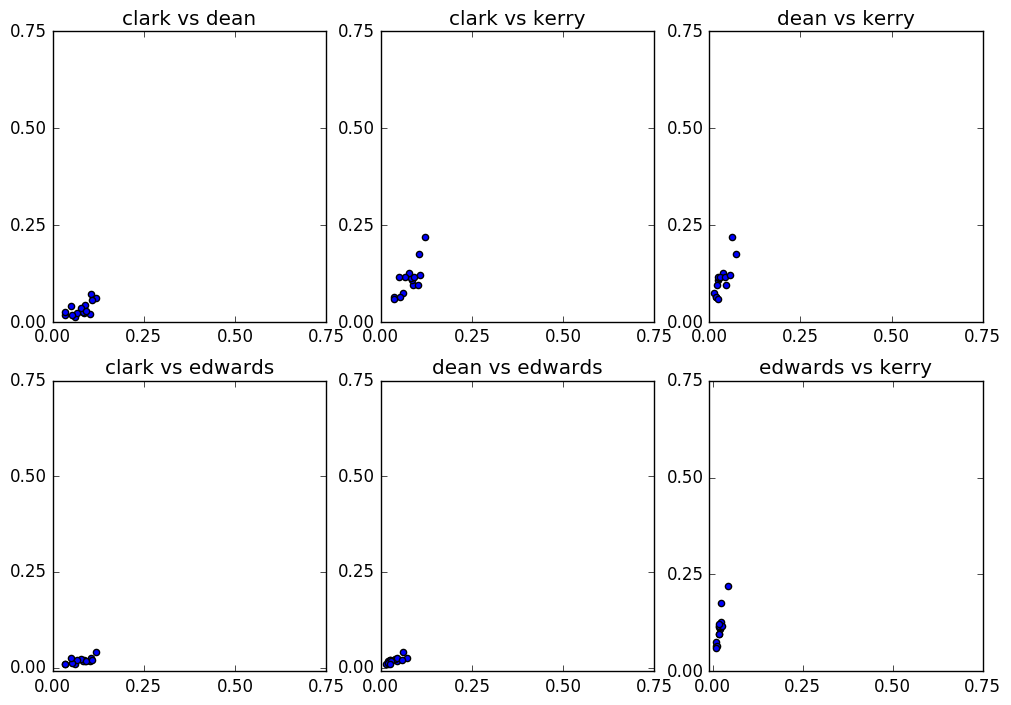

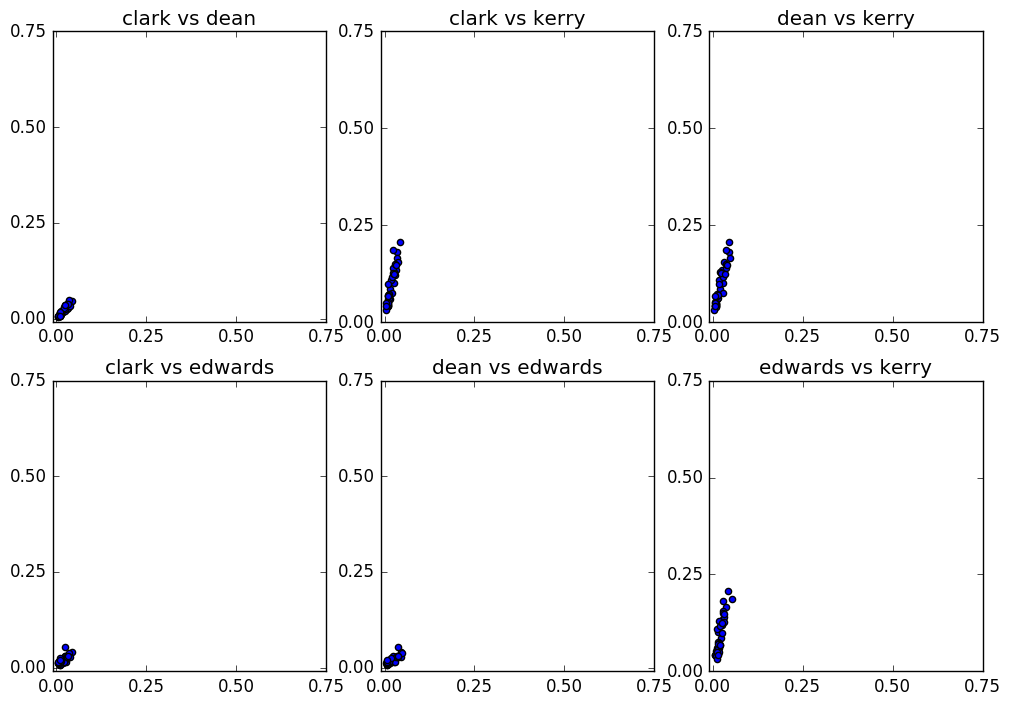

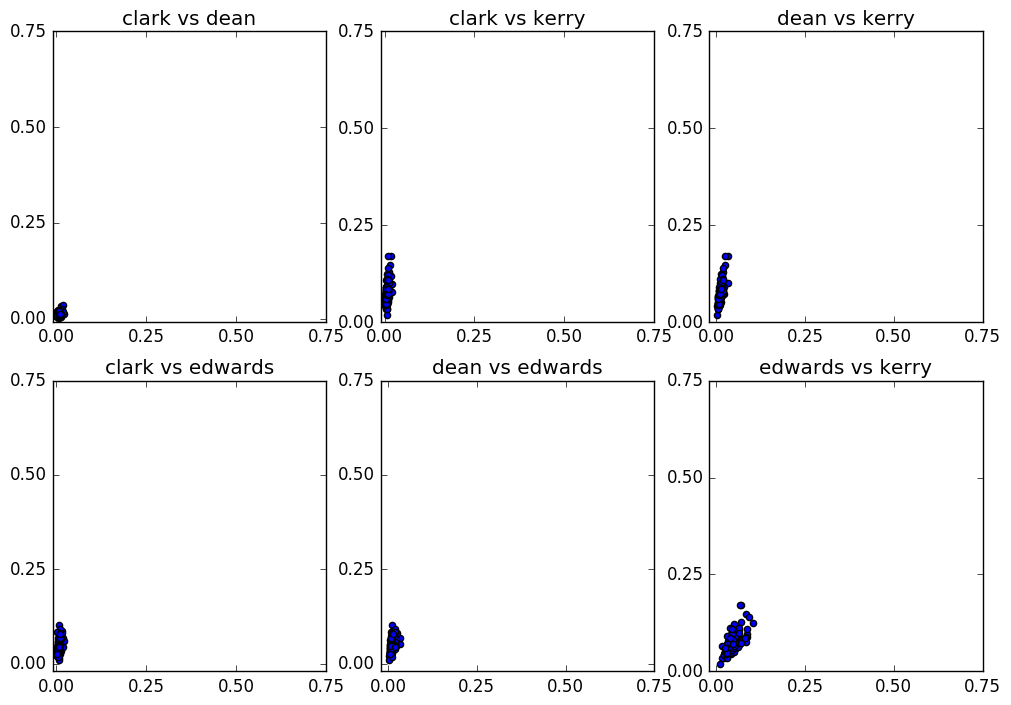

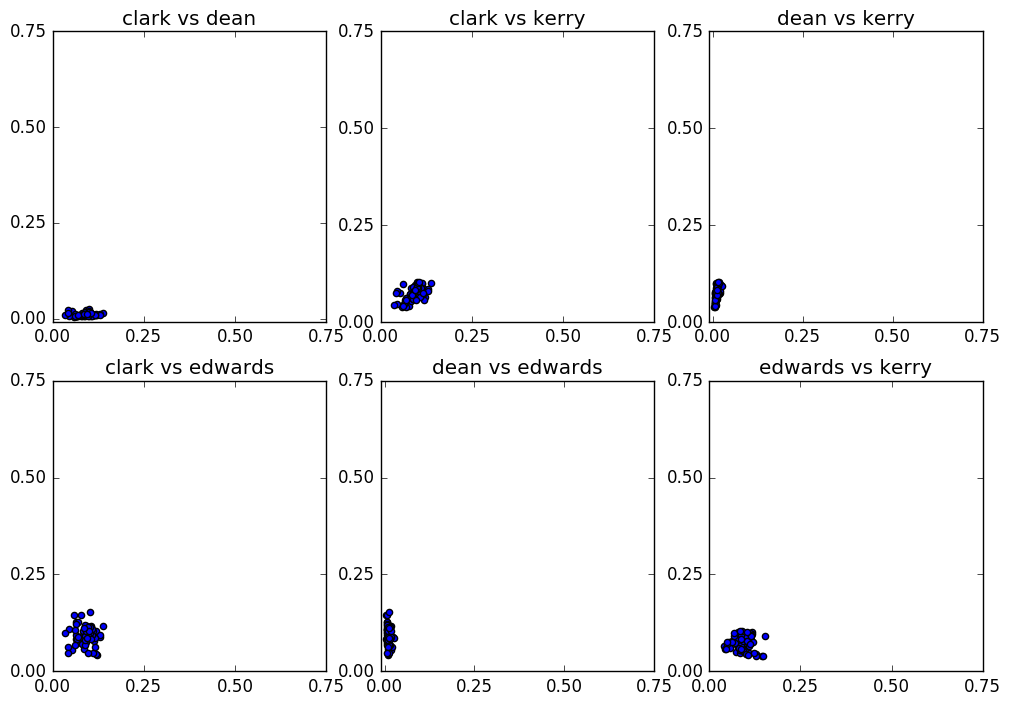

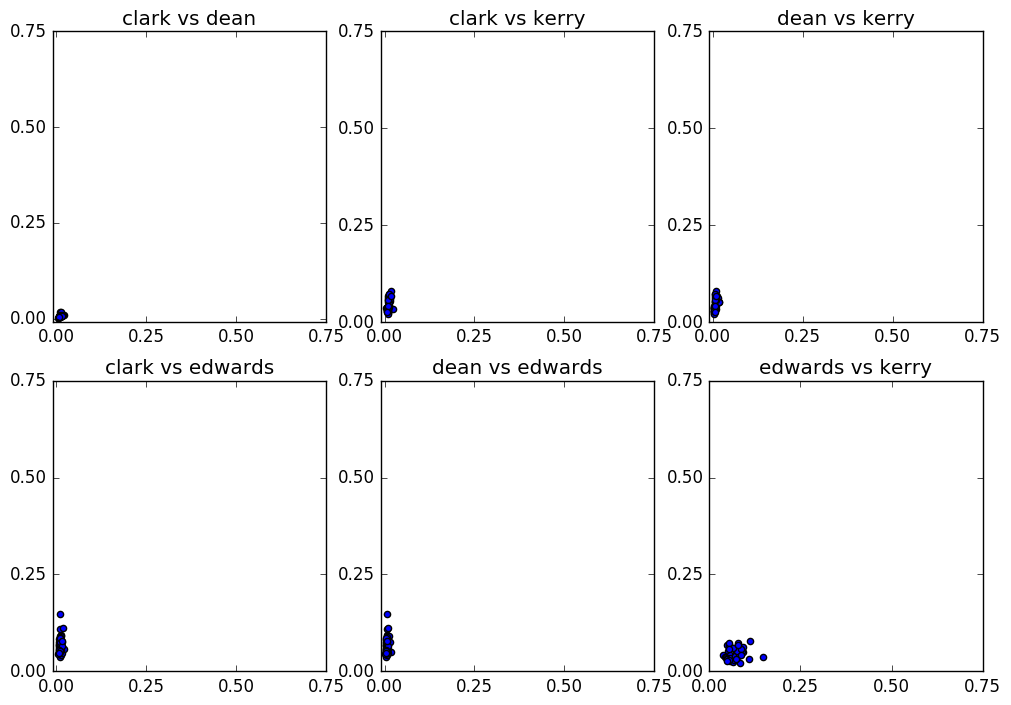

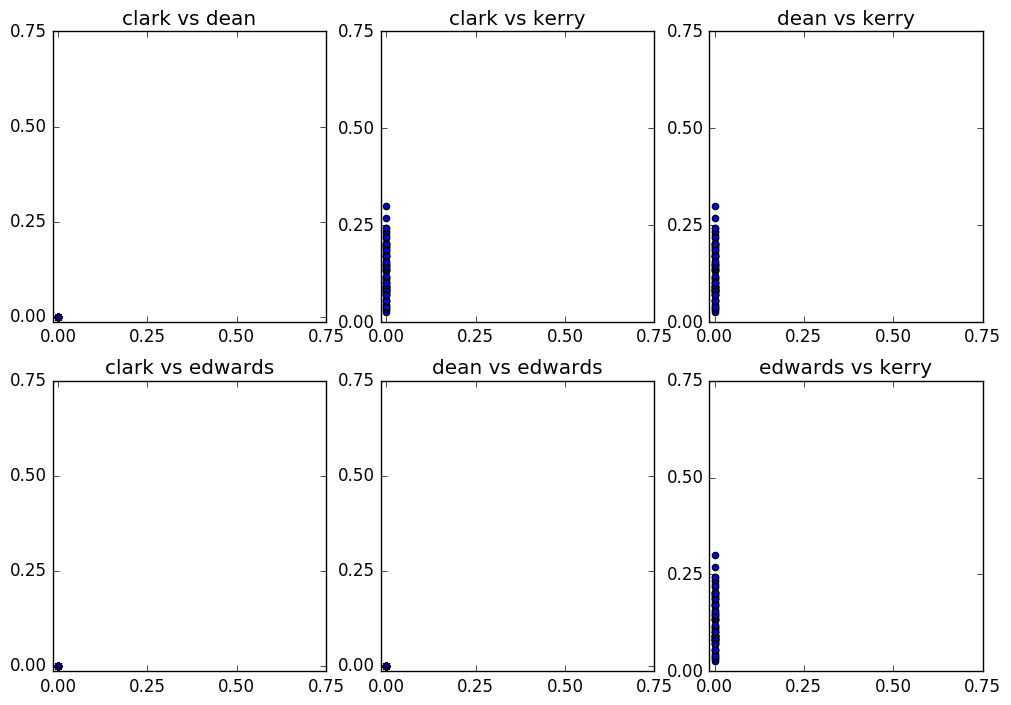

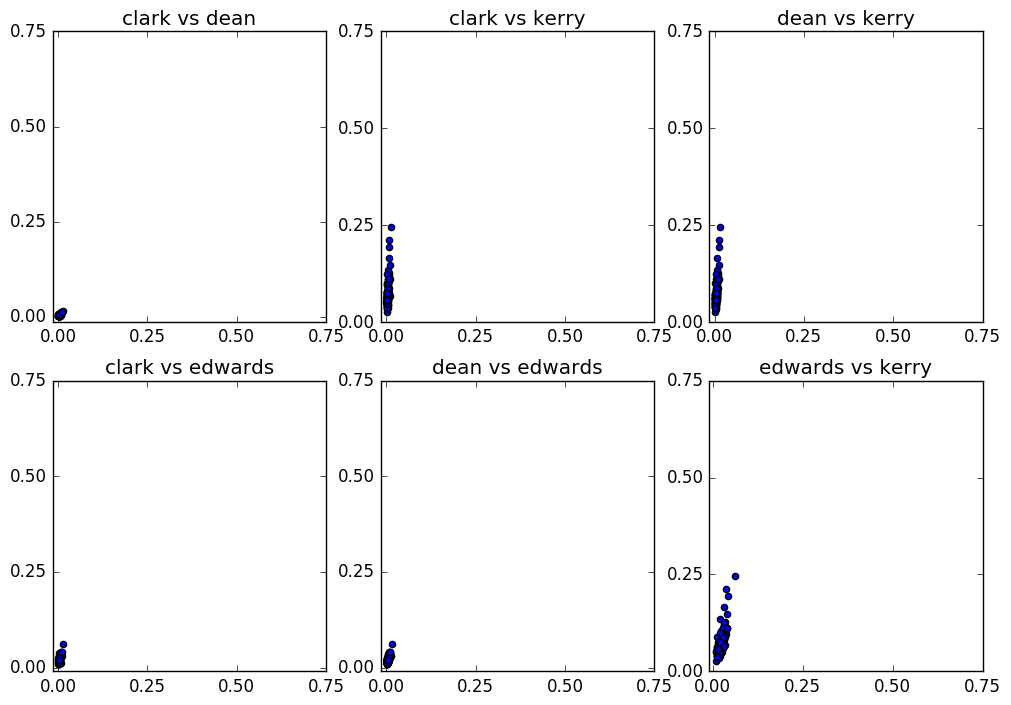

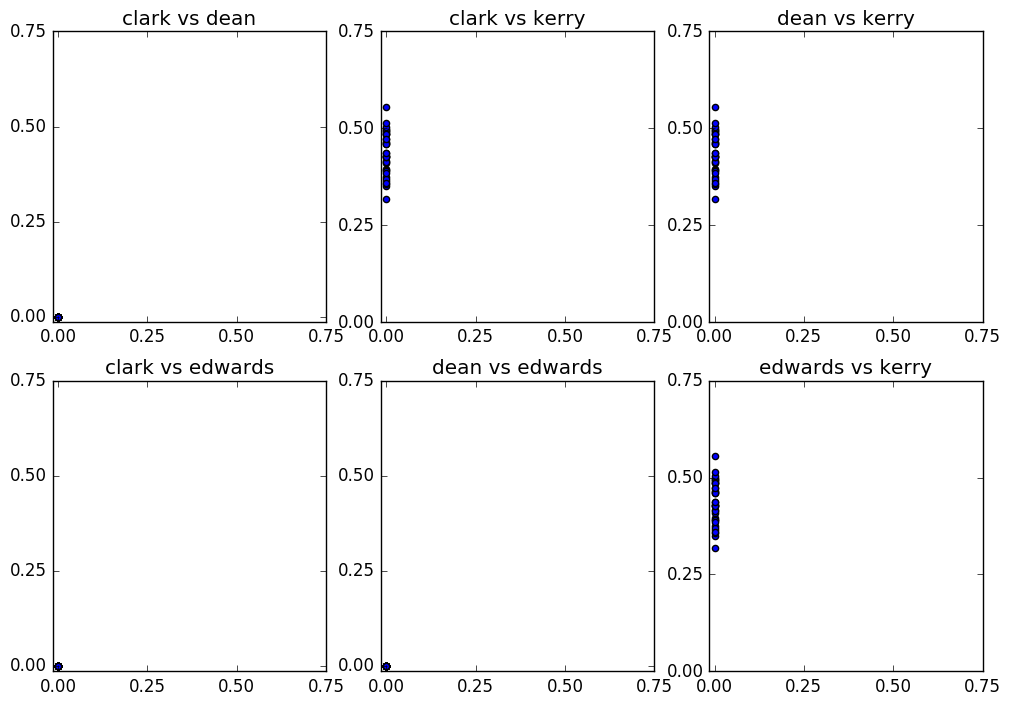

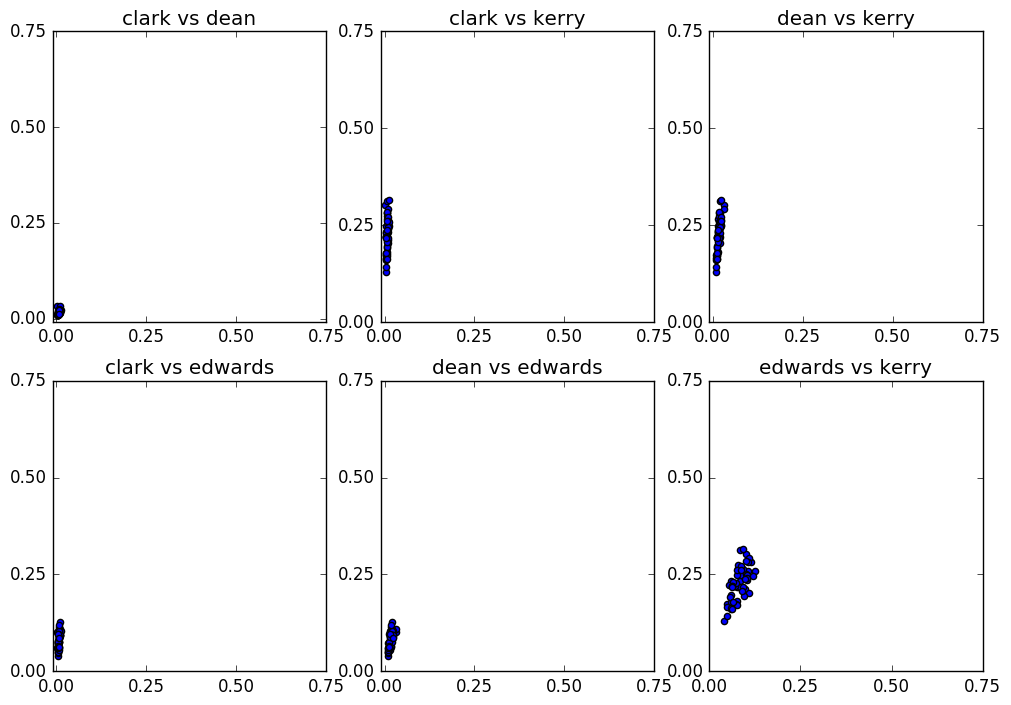

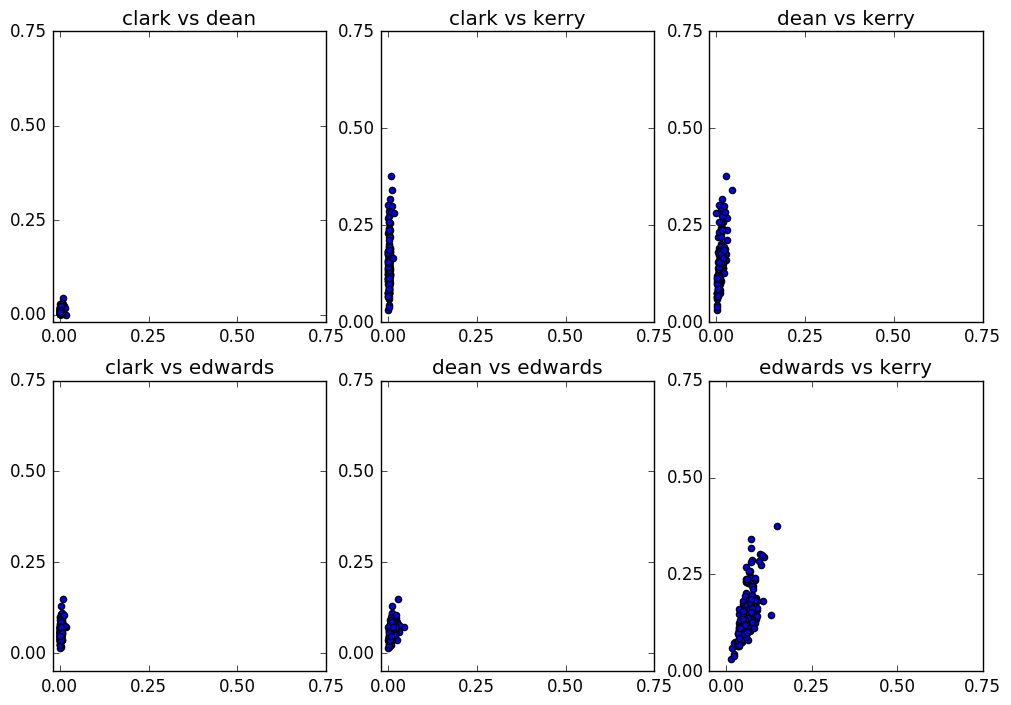

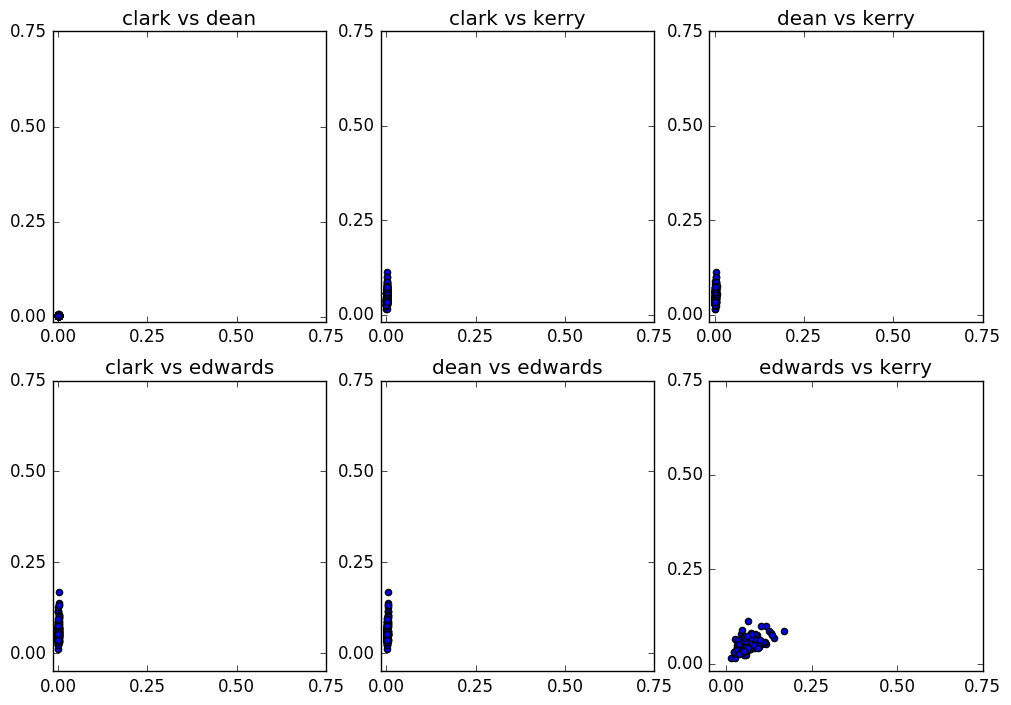

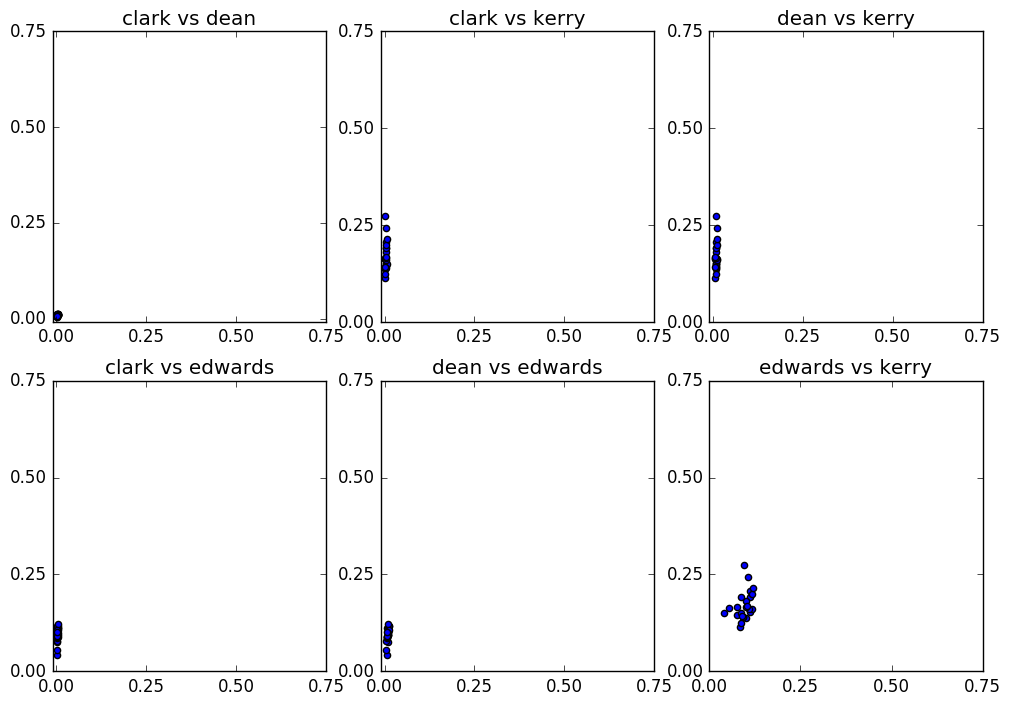

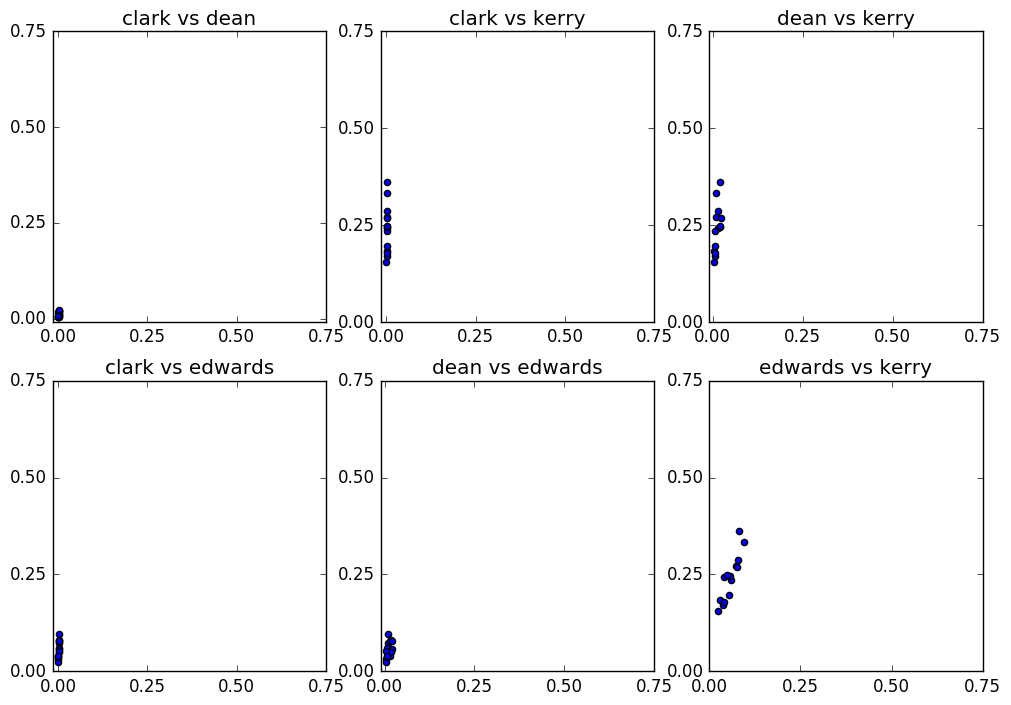

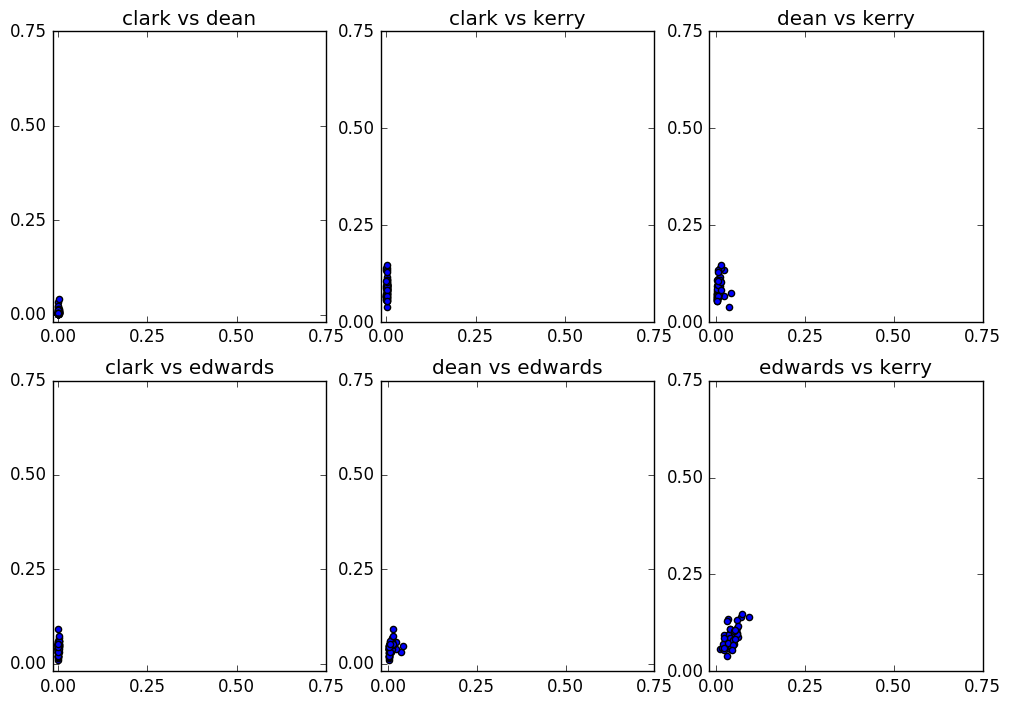

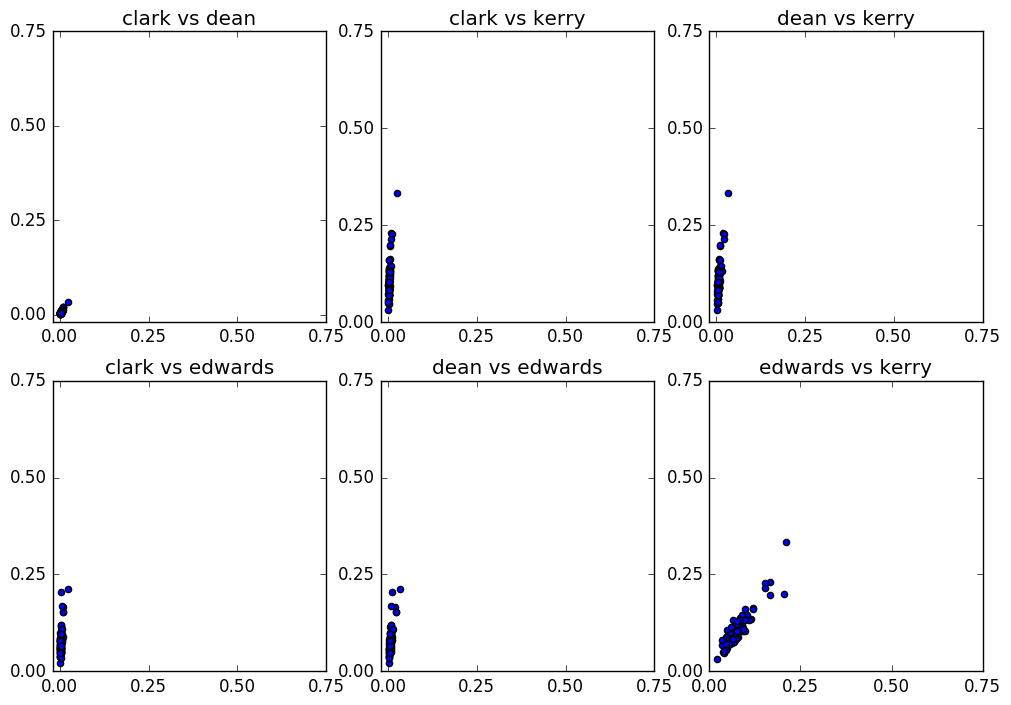

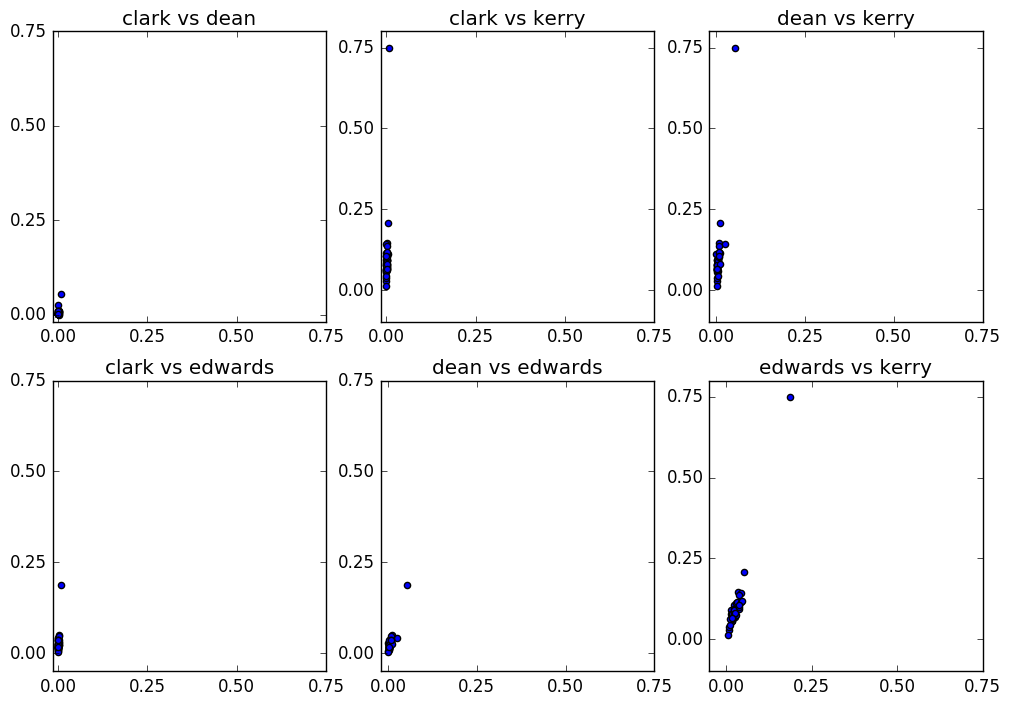

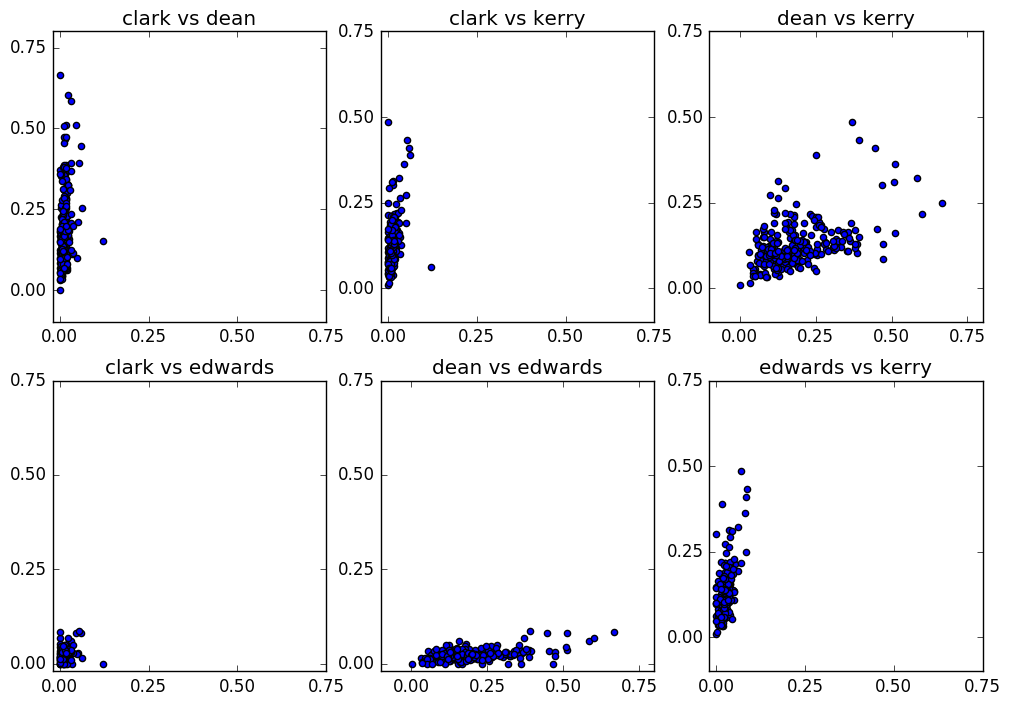

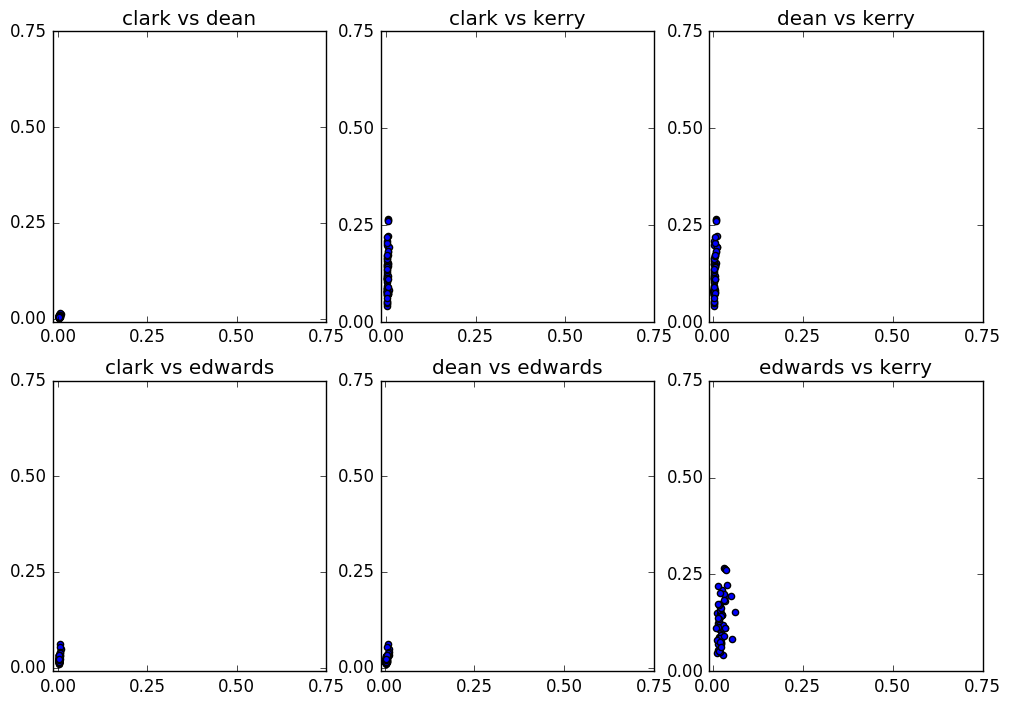

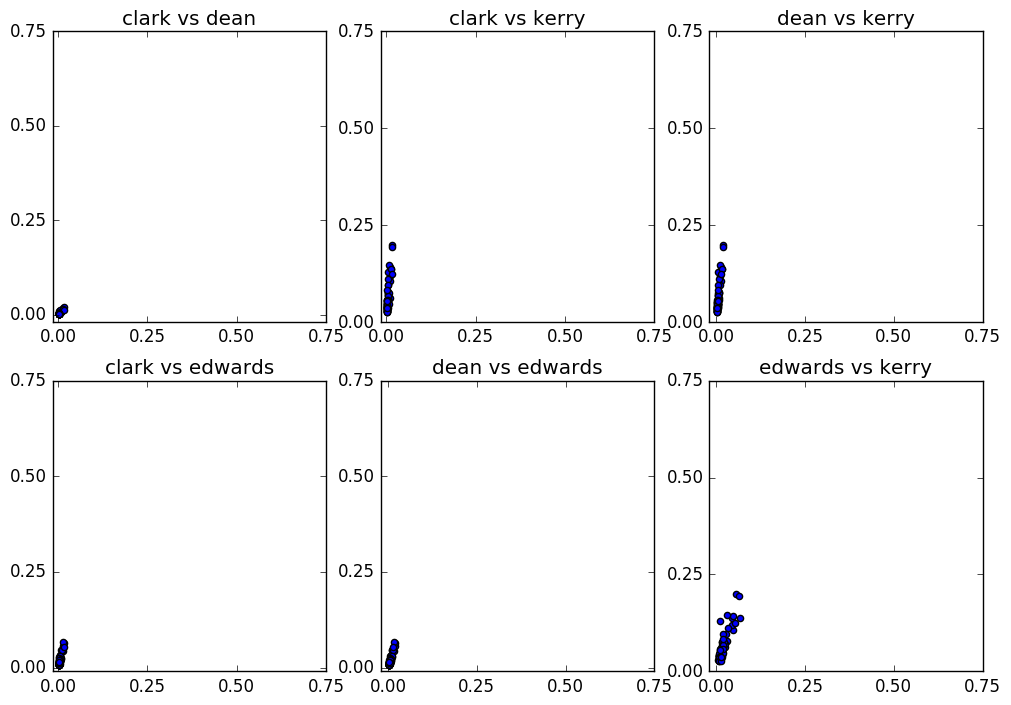

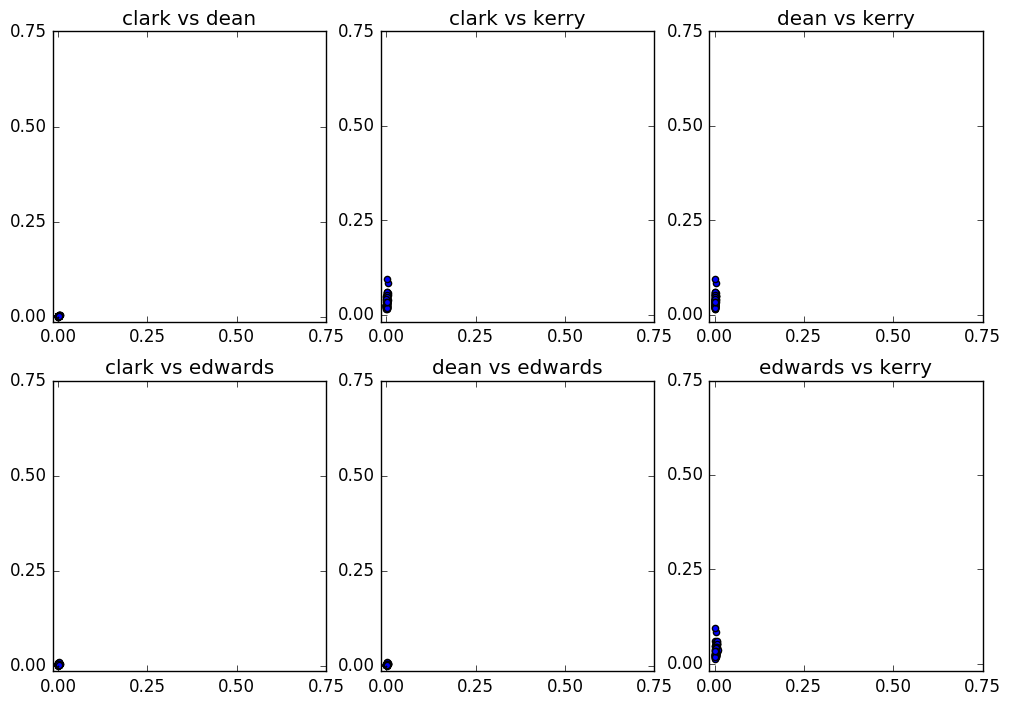

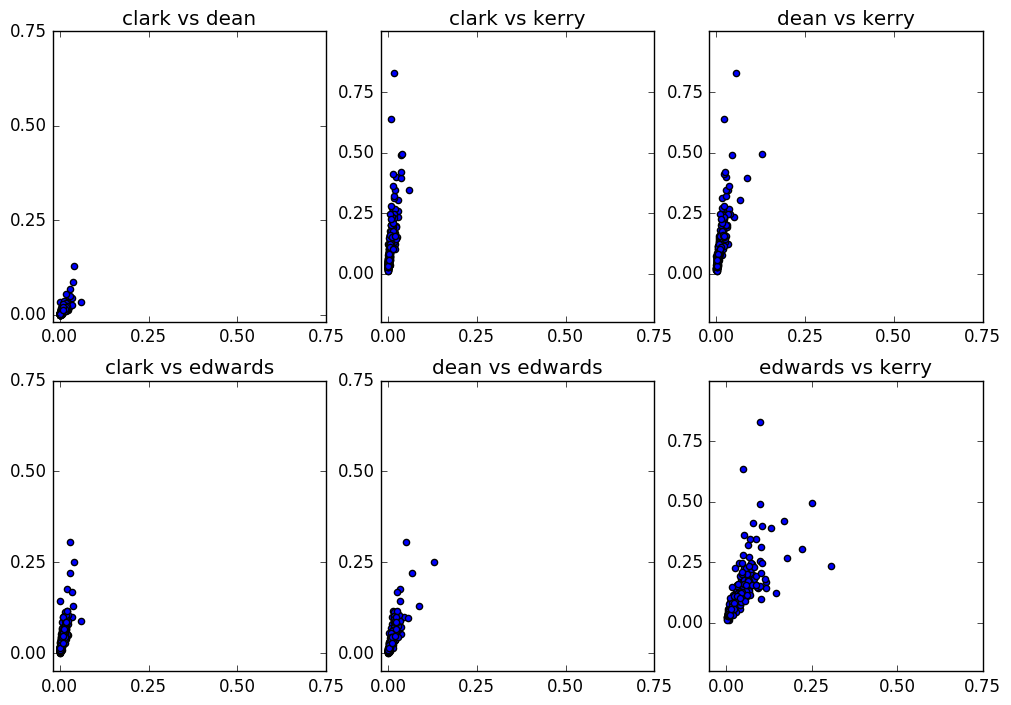

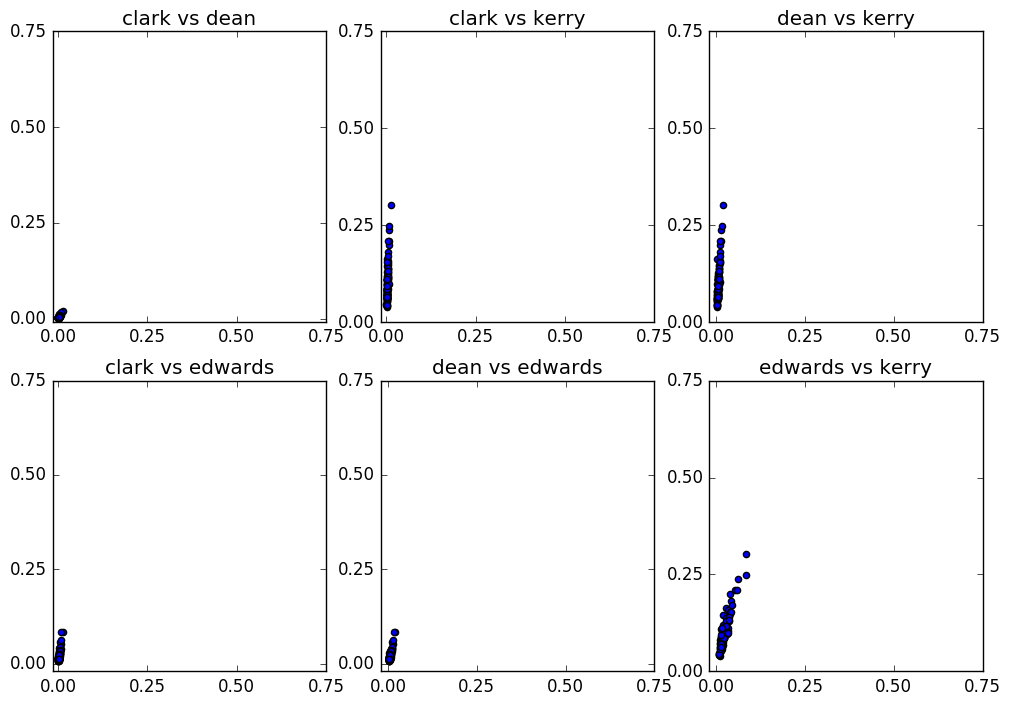

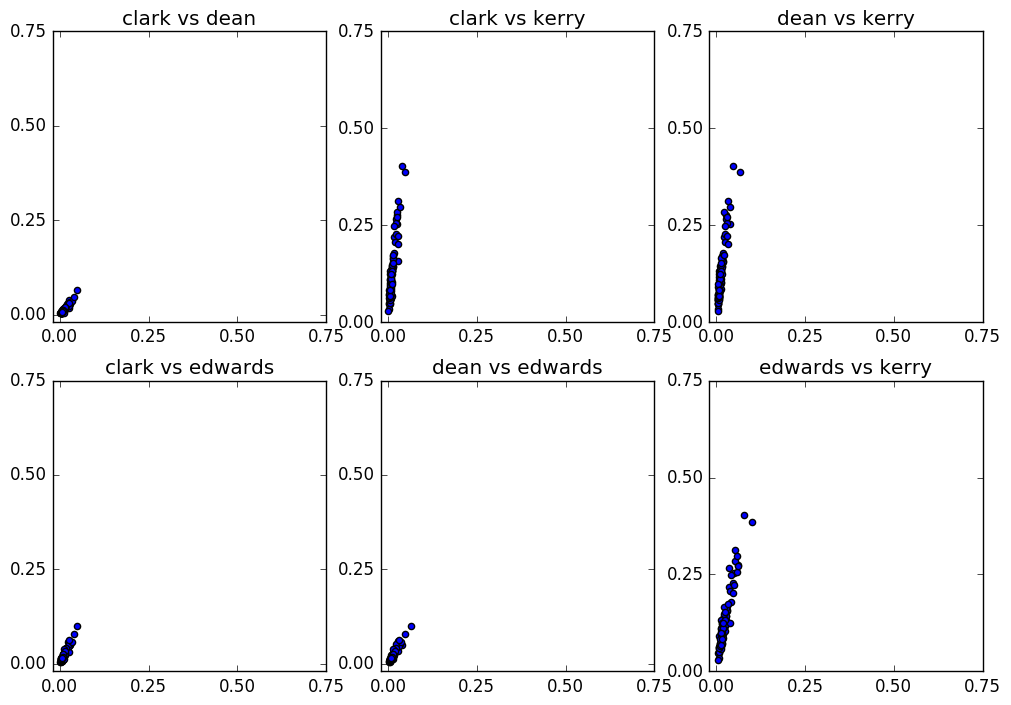

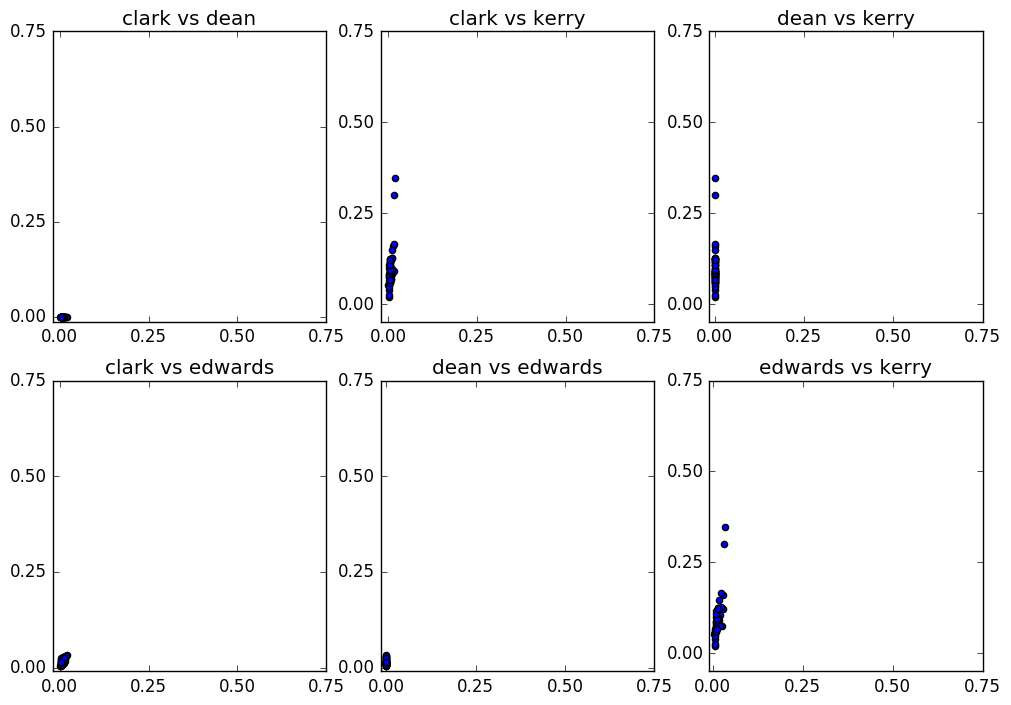

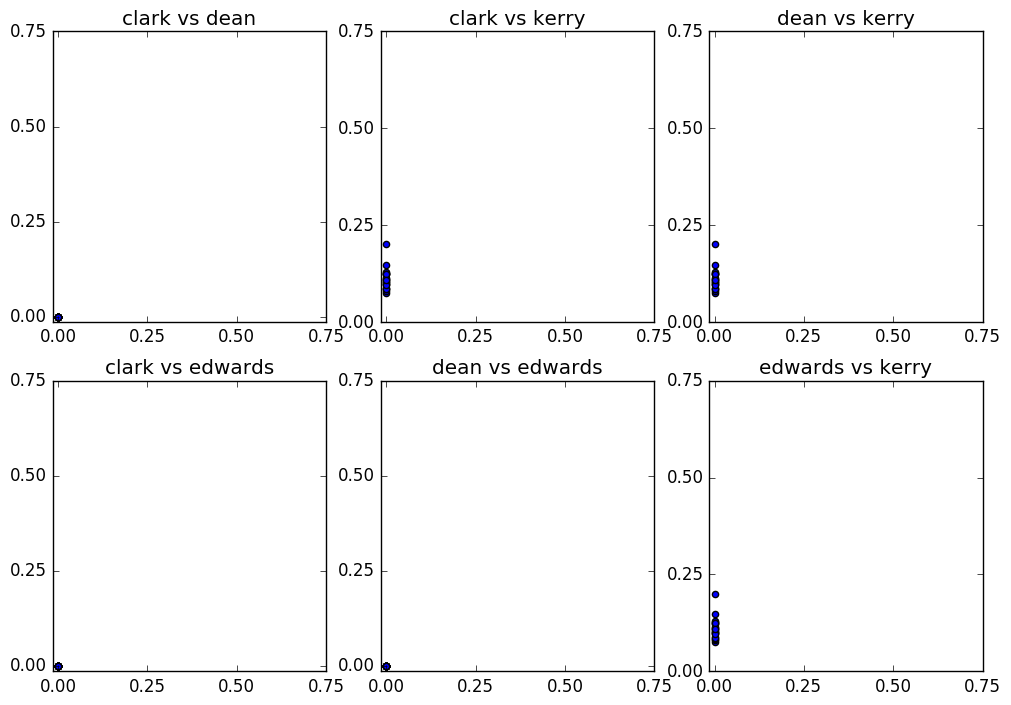

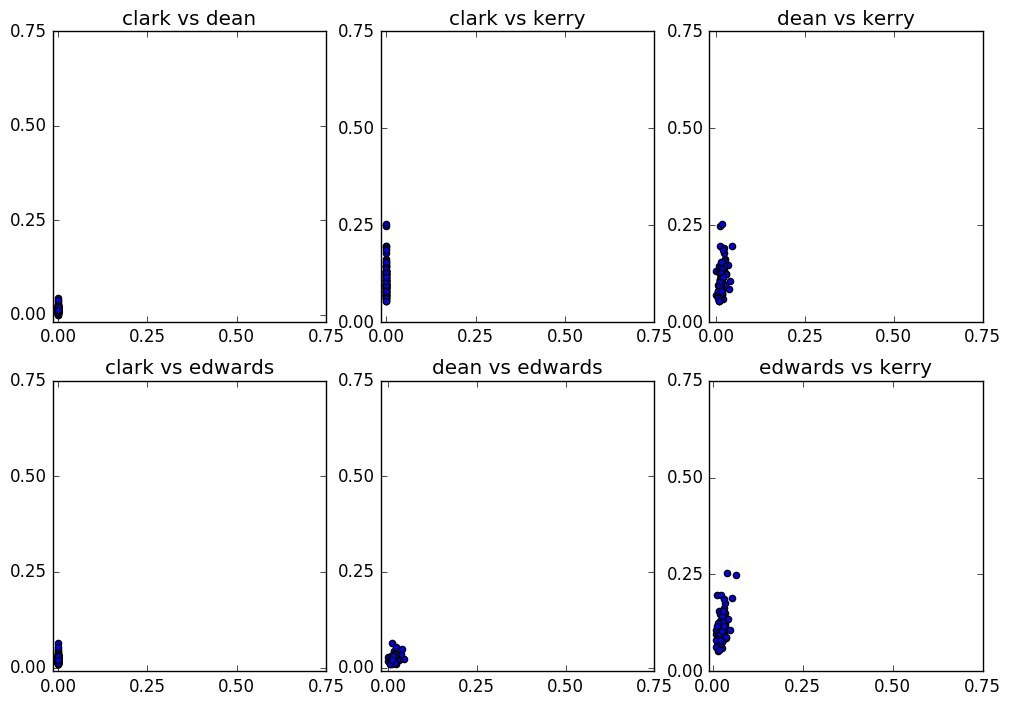

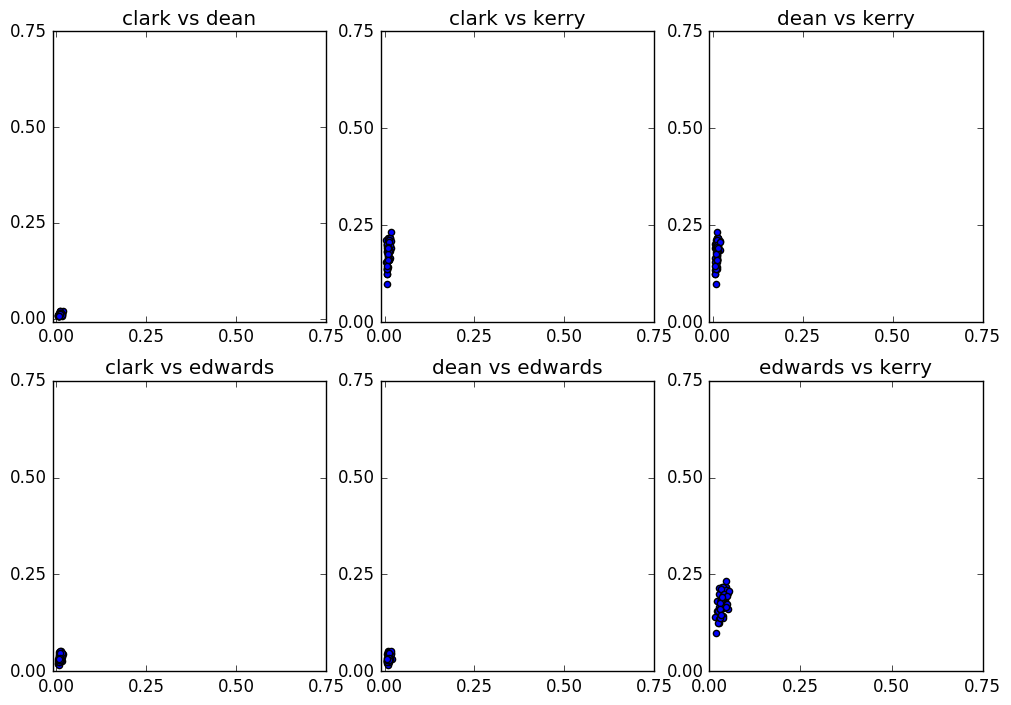

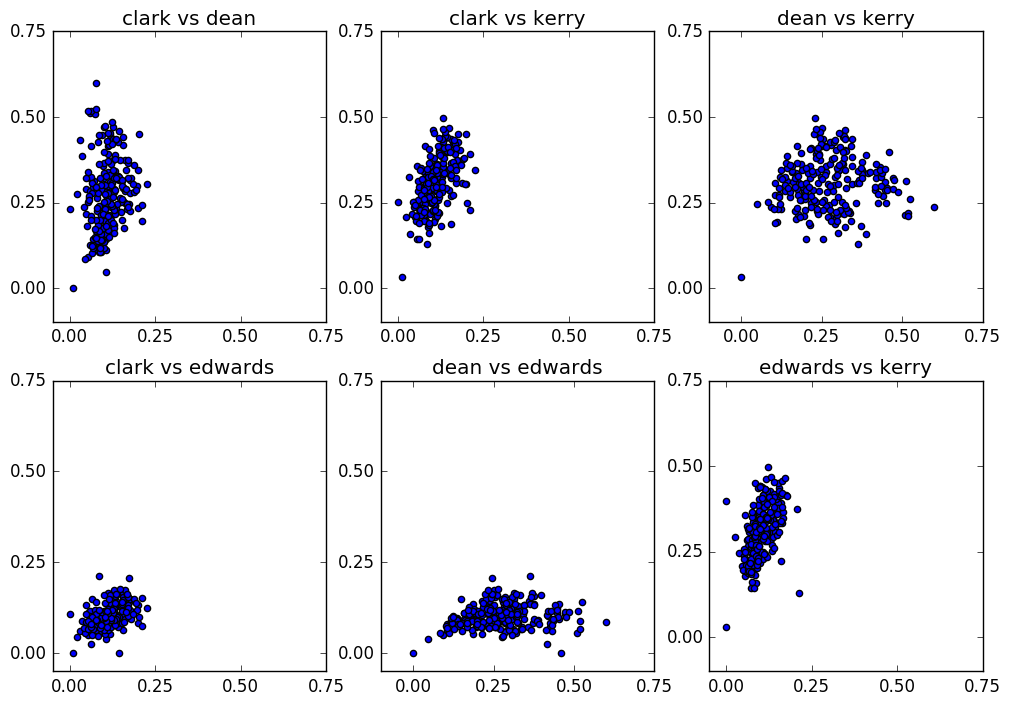

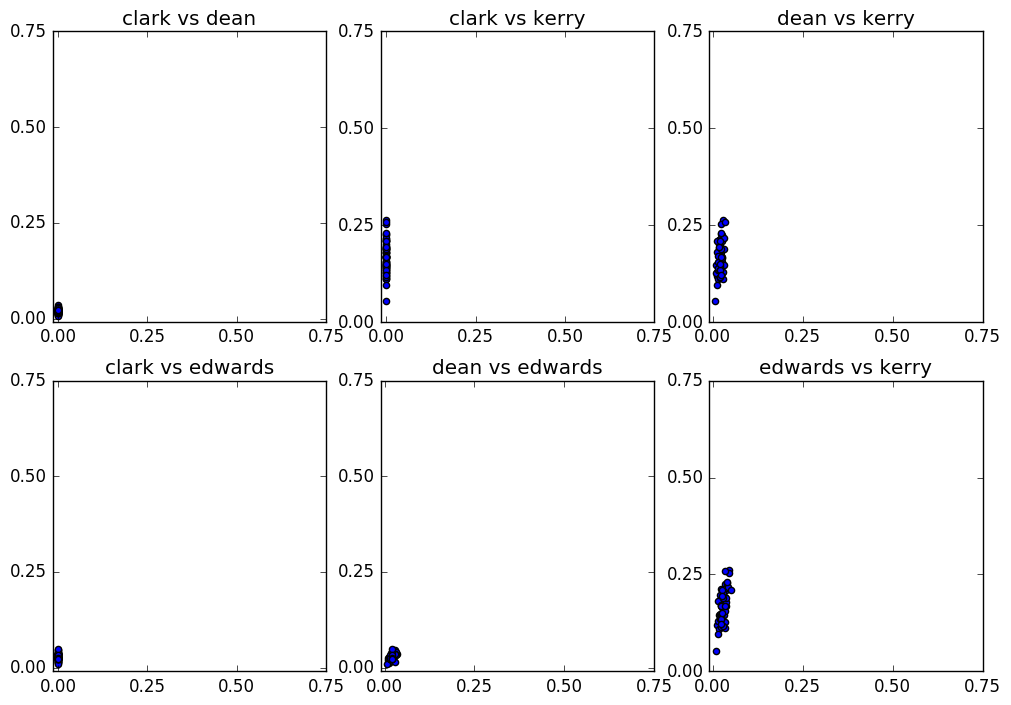

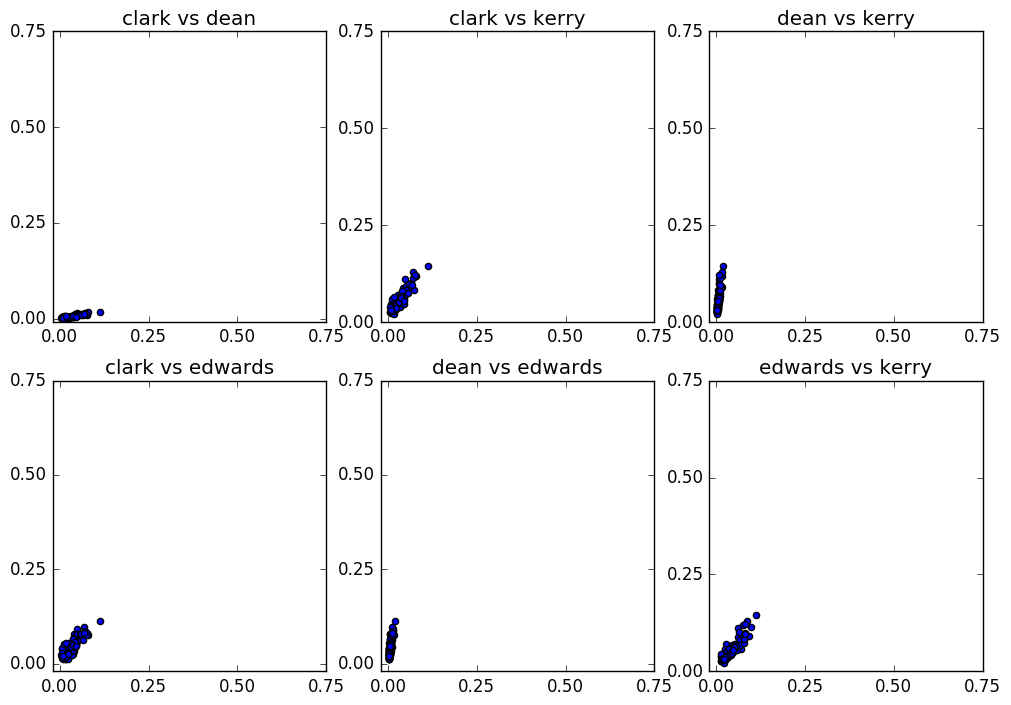

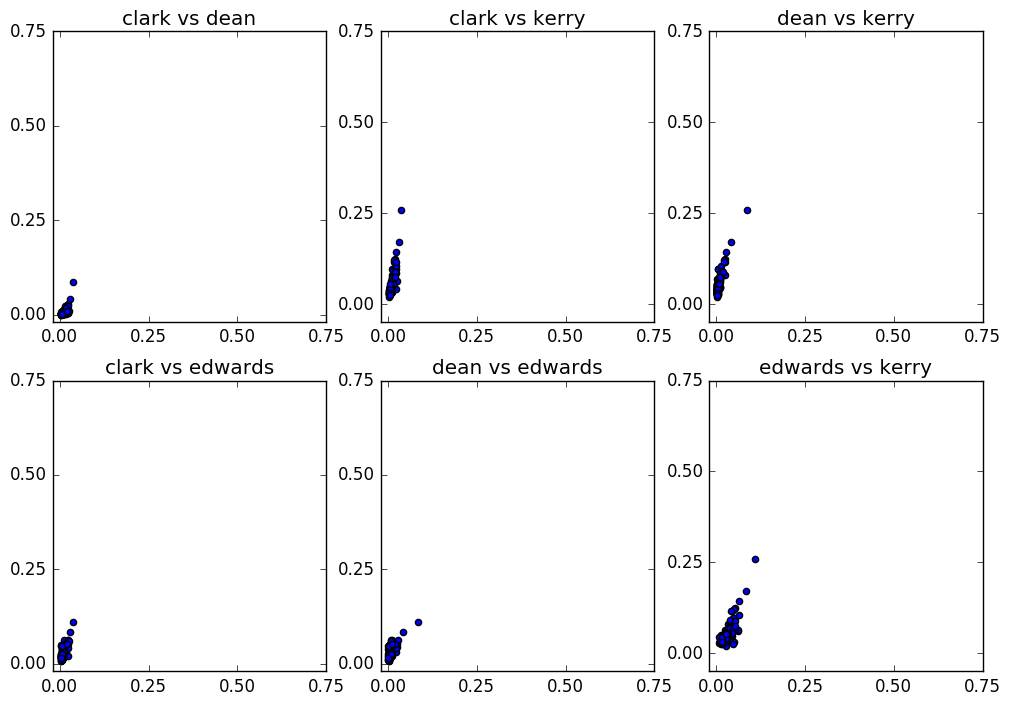

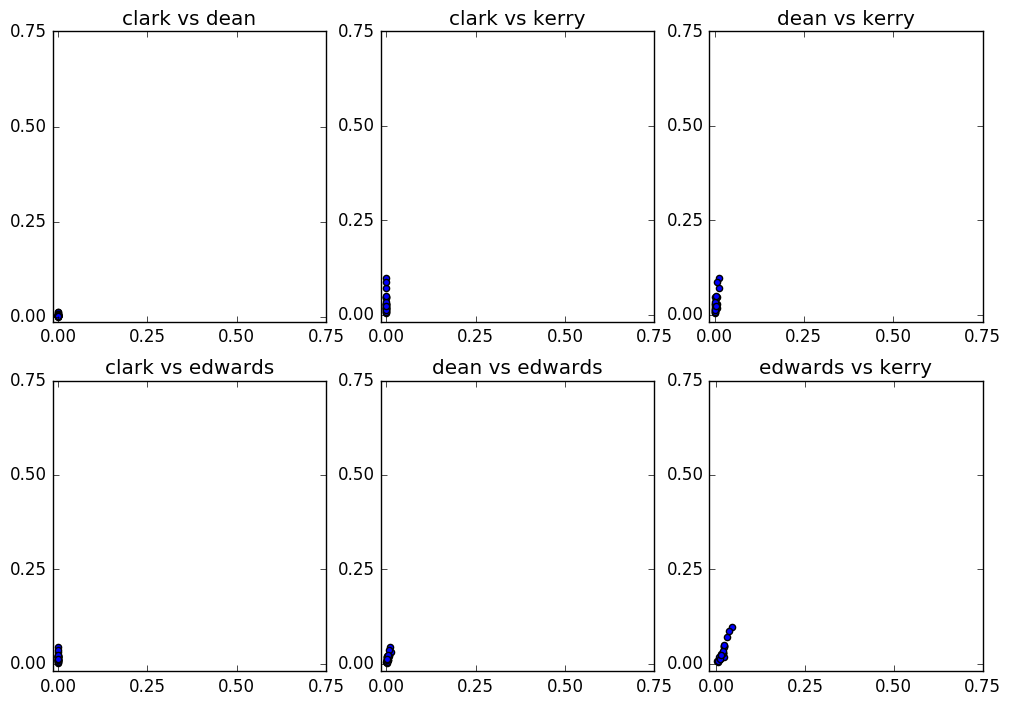

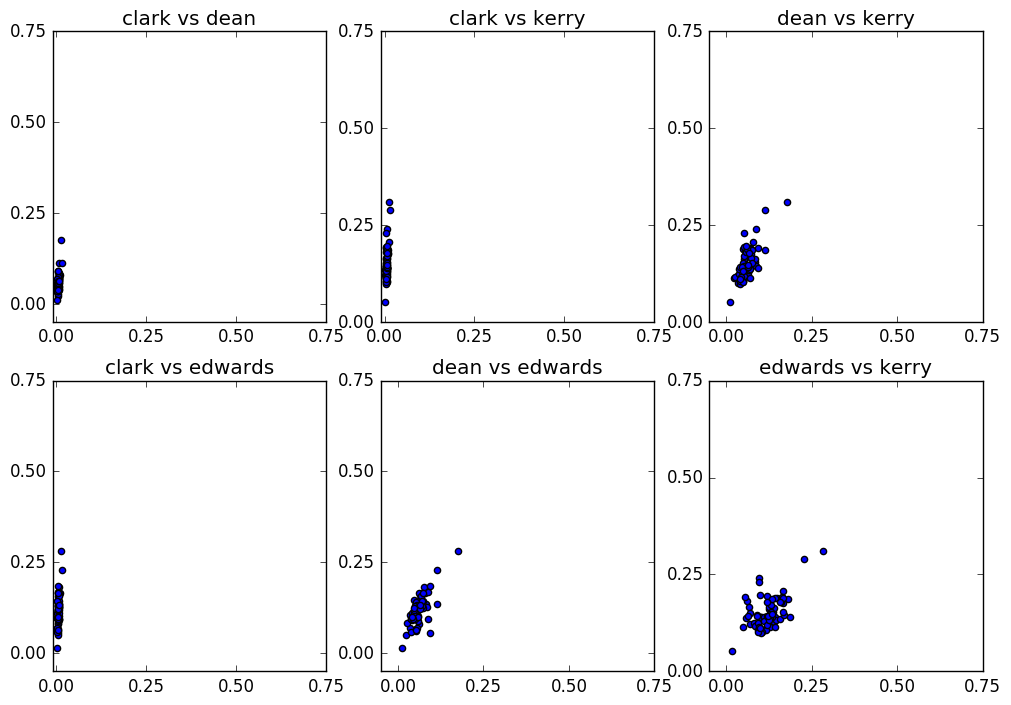

In [25]:
# Votes_sを用いる
plt = PyPlot
names = ["clark", "dean", "edwards", "kerry"]
DeltaO  = 0.6891
DeltaMO = 0.5366
combination = [(i, i+j) for i in 1:3 for j in 1:(4-i)]

for S in 1:size(Cand,1)

    DELTA = DeltaO*Open+DeltaMO*MOpen
    RTOT = RDemHat.*(1+DELTA)-VOther
    RTot_s = RTOT[Cand[S, 14]:Cand[S, 15], :]
    RTot_s = max(RTot_s, sum(Votes[Cand[S, 14]:Cand[S, 15], :], 2))
    Votes_s = Votes[Cand[S, 14]:Cand[S, 15], :]./(RTot_s*ones(1,4))

    num_rows, num_cols = 2, 3
    fig, axes = subplots(num_rows, num_cols, figsize=(12, 8))
    axes = vec(axes)

    # cand1 vs cand2で、cand1が横軸、cand2が縦軸
    for (n,c) in enumerate(combination)
        cand1 = names[c[1]]
        cand2 = names[c[2]]
        ax = axes[n]
        ax[:scatter](Votes_s[:, c[1]], Votes_s[:, c[2]])
        ax[:set_title]("$cand1 vs $cand2")
        ax[:set_xticks]([0,0.25,0.5,0.75])
        ax[:set_yticks]([0,0.25,0.5,0.75])
        savefig("state_number_$S")
    end
end
        
    


## パラメータは以下のとおり

```
FAlph = Array(Float64, 2, 1)
# setting parameters
param[2] = -1
C0 = 0
# Raceの変更に伴い、Cxも4つの要素にする必要がある。
q = 4
Cx = param[1:q]
Cz = -abs(param[q+1:q+3])
FAlph[1,1] = abs(param[q+4])
FAlph[2,1] = abs(param[q+5])
param[q+4:q+5] = FAlph[1:2,1]
Sig_xsi  = max(0.5, abs(param[q+6]))
param[q+6] = Sig_xsi
DeltaO  = 0.6891
DeltaMO = 0.5366
# Raceをいじった関係でこのvkを4*4 = 16この要素にしなくちゃいけない
vk = param[12:27]
composite = param[75:149]
Tij = abs(param[150:260])

# new parameters
# rho_eta = abs(param[261])
rho_eta = 1
rho_chi = param[262:265]
mu_chi = param[266:269]
chi = param[270:273]
```
